<h1 align="center">World food fact data analysis:</h1> 

***
In this project, we worked on the world food facts data, which is composed of 356027 product and 163 features. First, we did explore the data, clean it, and then performed the required tasks. 

In [1]:
import pandas as pd # pandas: data analysis library
import numpy as np # numpy: numerical computing library.
import seaborn as sns # seaborn: data visualization library
import matplotlib.pyplot as plt #matplotlib: data visualization library
import matplotlib.dates as mdates
from scipy.interpolate import make_interp_spline
import scipy.stats as stats #Scipy module contains a large number of probability distributions as well as a growing library of statistical functions
import json #Library parses JSON into a Python dictionary or list
from pylab import *
import string
import re
import sqlite3


pd.set_option('display.max_columns', None) #Option to disply all columns

%matplotlib inline

## Importing the data 

***
Importing the data as dataframe using `read_csv` and store it under the name df.

In [2]:
df = pd.read_csv('../en.openfoodfacts.org.products.tsv', sep="\t", low_memory = False)

***

## Initial data exploration

***
The number of rows and columns of the dataframe 'df' can be consulted using property `shap`. 

In [3]:
df.shape

(356027, 163)

As stated before, we have a dataframe with 356027 rows (products), and 163 columns (features)
***

We Calculate the ratio of missing data in the dataframe.

In [4]:
print ('Number of observations = ', df.size) 
print ('Number of Missing values = ', df.isnull().sum().sum()) 
print('The percentage of missing values',"%.0f%%" % ((1-((df.size-df.isnull().sum().sum())/df.size))*100))

Number of observations =  58032401
Number of Missing values =  44183489
The percentage of missing values 76%


The result shows that over 3/4 of the data is missing.
***

We drop the columns with high (< 3/4) missing data.

In [5]:
df = df.dropna(thresh=int(df.shape[0] * .25), axis=1).copy()
df.shape

(356027, 52)

This step allow us to reduce the number of features and remove columns of high missing data.
***

* We drop the deplicated rows

In [6]:
df.drop_duplicates(inplace=True)

***

* We plot the ratio of missing data.

In [7]:
plt.style.use('fivethirtyeight')

df_missing = df.isnull().sum()
df_missing_ratio= (df_missing/df.shape[0])*100

bar_plot_md = df_missing_ratio.sort_values().plot(kind = 'barh',
                                                  figsize=(20,20),
                                                  edgecolor='black',
                                                  grid=False,
                                                  color='teal',
                                                  fontsize=20,
                                                  alpha=0.6)

bar_plot_md.set_title('The ratio of missing data peer feature ', fontsize=40)
bar_plot_md.set_xlabel('Percentage of missing data', fontsize=20)
bar_plot_md.set_ylabel('Features', fontsize=20)

bar_plot_md.grid(True)

plt.show()

The graphe illustrate that there is a high amount of messing data in different columns.
 ***

The products features are composed of columns with type 'object' and 'float64'

In [8]:
df.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

***

### Categorical columns exploration 

***
The dataframe has 32 'object' columns, hence '20' 'float' columns. 

In [9]:
print('The total number of categorical columns = ',df.loc[:, df.dtypes == object].shape[1])

The total number of categorical columns =  32


***
We print the first rows ad explore their composition.

In [10]:
df.loc[:, df.dtypes == object].tail(10)

code                                                url  \
356017       99111250  http://world-en.openfoodfacts.org/product/9911...   
356018           9918  http://world-en.openfoodfacts.org/product/9918...   
356019  9935010000003  http://world-en.openfoodfacts.org/product/9935...   
356020       99410148  http://world-en.openfoodfacts.org/product/9941...   
356021  9948282780603  http://world-en.openfoodfacts.org/product/9948...   
356022       99567453  http://world-en.openfoodfacts.org/product/9956...   
356023  9970229501521  http://world-en.openfoodfacts.org/product/9970...   
356024  9977471758307  http://world-en.openfoodfacts.org/product/9977...   
356025  9980282863788  http://world-en.openfoodfacts.org/product/9980...   
356026   999990026839  http://world-en.openfoodfacts.org/product/9999...   

                           creator   created_t      created_datetime  \
356017                    balooval  1367163039  2013-04-28T15:30:39Z   
356018                  woshilapin  1430167954  2015-04-27T20:52:34Z   
356019                    sebleouf  1446293229  2015-10-31T12:07:09Z   
356020             date-limite-app  1463936572  2016-05-22T17:02:52Z   
356021  openfoodfacts-contributors  1490631299  2017-03-27T16:14:59Z   
356022             usda-ndb-import  1489059076  2017-03-09T11:31:16Z   
356023                      tomato  1422099377  2015-01-24T11:36:17Z   
356024  openfoodfacts-contributors  1497018549  2017-06-09T14:29:09Z   
356025  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
356026             usda-ndb-import  1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
356017      1371690556   2013-06-20T01:09:16Z   
356018      1430167992   2015-04-27T20:53:12Z   
356019      1446376839   2015-11-01T11:20:39Z   
356020      1491244498   2017-04-03T18:34:58Z   
356021      1491244498   2017-04-03T18:34:58Z   
356022      1491244499   2017-04-03T18:34:59Z   
356023      1491244499   2017-04-03T18:34:59Z   
356024      1500730305   2017-07-22T13:31:45Z   
356025      1492340089   2017-04-16T10:54:49Z   
356026      1491244499   2017-04-03T18:34:59Z   

                                             product_name quantity  \
356017                                 Thé vert Earl grey     50 g   
356018                         Cheese cake thé vert, yuzu      NaN   
356019                                     Rillette d'oie    180 g   
356020                                                NaN      NaN   
356021                                  Tomato & ricotta         1   
356022  Mint Melange Tea A Blend Of Peppermint, Lemon ...      NaN   
356023                                            乐吧泡菜味薯片     50 g   
356024                                      Biscottes bio     300g   
356025                           Tomates aux Vermicelles       67g   
356026                    Sugar Free Drink Mix, Peach Tea      NaN   

           packaging packaging_tags                 brands  \
356017  boîte,carton   boite,carton                Lobodis   
356018           NaN            NaN                    NaN   
356019     Pot,Verre      pot,verre  Sans marque,D.Lambert   
356020     Plastique      plastique                    NaN   
356021     Plastique      plastique               Panzani    
356022     Plastique      plastique           Trader Joe's   
356023     Plastique      plastique                     乐吧   
356024           NaN            NaN           Leader Price   
356025           NaN            NaN                  Knorr   
356026     Plastique      plastique          Market Pantry   

                  brands_tags  \
356017                lobodis   
356018                    NaN   
356019  sans-marque,d-lambert   
356020                    NaN   
356021                panzani   
356022           trader-joe-s   
356023                     乐吧   
356024           leader-price   
356025                  knorr   
356026          market-pantry   

                             

 In brief, we could deduce from the table above that:
   * Some columns seem identical, in our case we will keep the more appropriate.
   * There are columns with list values.
***

The pnns_groups_1 represent the products categories. let's explore the ratio of number of products peer category. 

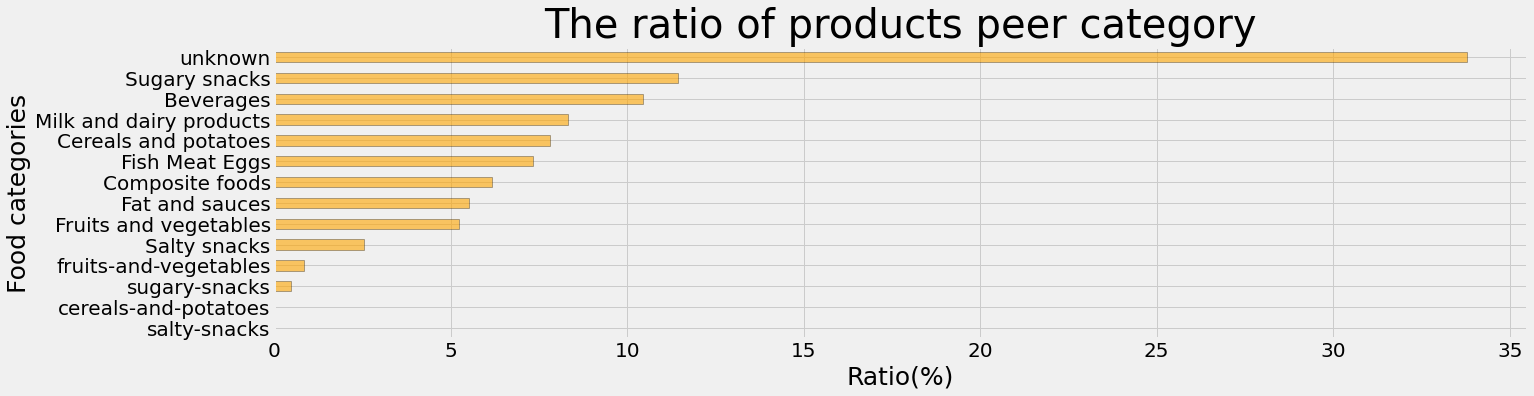

In [11]:
df_count_p1 = df.groupby('pnns_groups_1')['pnns_groups_1'].count()
df_count_p1_ratio = (df_count_p1/df['pnns_groups_1'].notnull().sum())*100

bar_plot_p1 = df_count_p1_ratio.sort_values().plot(kind = 'barh',
                                                    figsize=(20,5),
                                                    edgecolor='black',
                                                    grid=False,
                                                    color='orange',
                                                    fontsize=20,
                                                    alpha = 0.6)

bar_plot_p1.set_title('The ratio of products peer category', fontsize=40)
bar_plot_p1.set_xlabel('Ratio(%)', fontsize=25)
bar_plot_p1.set_ylabel('Food categories', fontsize=25)

bar_plot_p1.grid(True)

plt.show()

Almost 35% of the products have an unknown category, which leaves us with 65%, and for the figures of missing data, we did see that pnns1 have 60% missing data.


***

What are the brands with more products in the data set?

In [12]:
df_count_br = df.groupby('brands')['brands'].count()
df_count_br_ratio = (df_count_br/df['brands'].notnull().sum())*100

bar_plot_br = df_count_br_ratio.sort_values().tail(10).plot(kind= 'barh',
                                                           figsize=(20,5),
                                                           edgecolor='black',
                                                           grid=False,
                                                           color='teal',
                                                           fontsize=20,
                                                           rot=0,
                                                           alpha = 0.6)

bar_plot_br.set_title('Top brands with the highst number of products', fontsize=40)
bar_plot_br.set_xlabel('Ratio(%)', fontsize=25)
bar_plot_br.set_ylabel('Brands', fontsize=25)

bar_plot_br.grid(True)

plt.show()

The top brands with more products are French brands, and they consititue only small portion of the brands. Hence, we have high number of brands. 
***

What is the origin of the products?

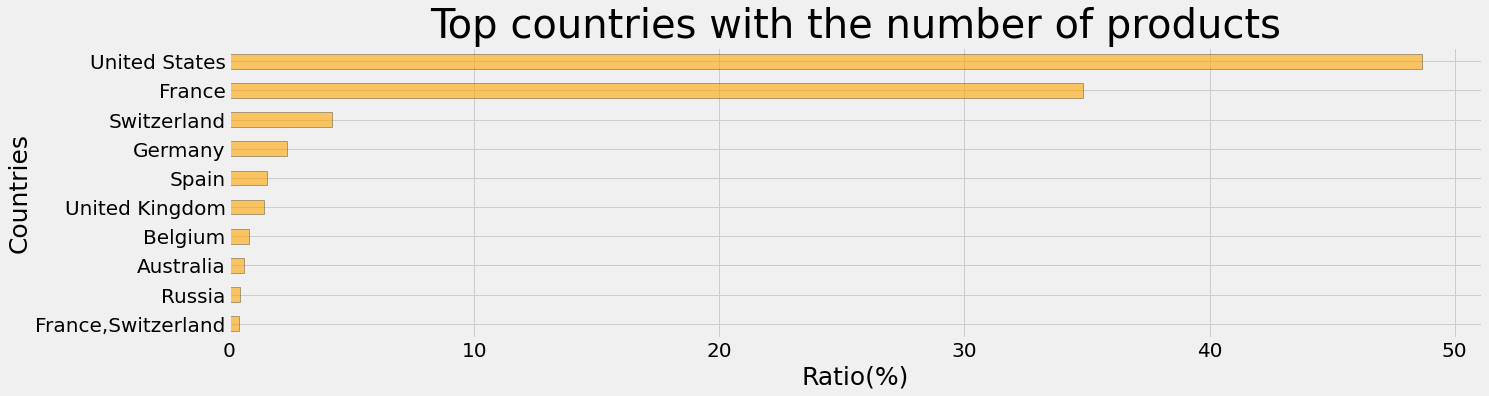

In [13]:
df_count_c = df.groupby('countries_en')['countries_en'].count()
df_count_c_ratio = (df_count_c/df['countries_en'].notnull().sum())*100

bar_plot_c = df_count_c_ratio.sort_values().tail(10).plot(kind= 'barh',
                                                           figsize=(20,5),
                                                           edgecolor='black',
                                                           grid=False,
                                                           color='orange',
                                                           fontsize=20,
                                                           rot=0,
                                                           alpha = 0.6)

bar_plot_c.set_title('Top countries with the number of products', fontsize=40)
bar_plot_c.set_xlabel('Ratio(%)', fontsize=25)
bar_plot_c.set_ylabel('Countries', fontsize=25)

bar_plot_c.grid(True)

plt.show()

More than 80% of the products come from the USA and France, and certain products are shared between countries.
***

What is the percentage of missing data peer feature for the countries with the highest data point?  

The answer to this question will allow us to observe the common features with less missing data, to maximas the data retantion.

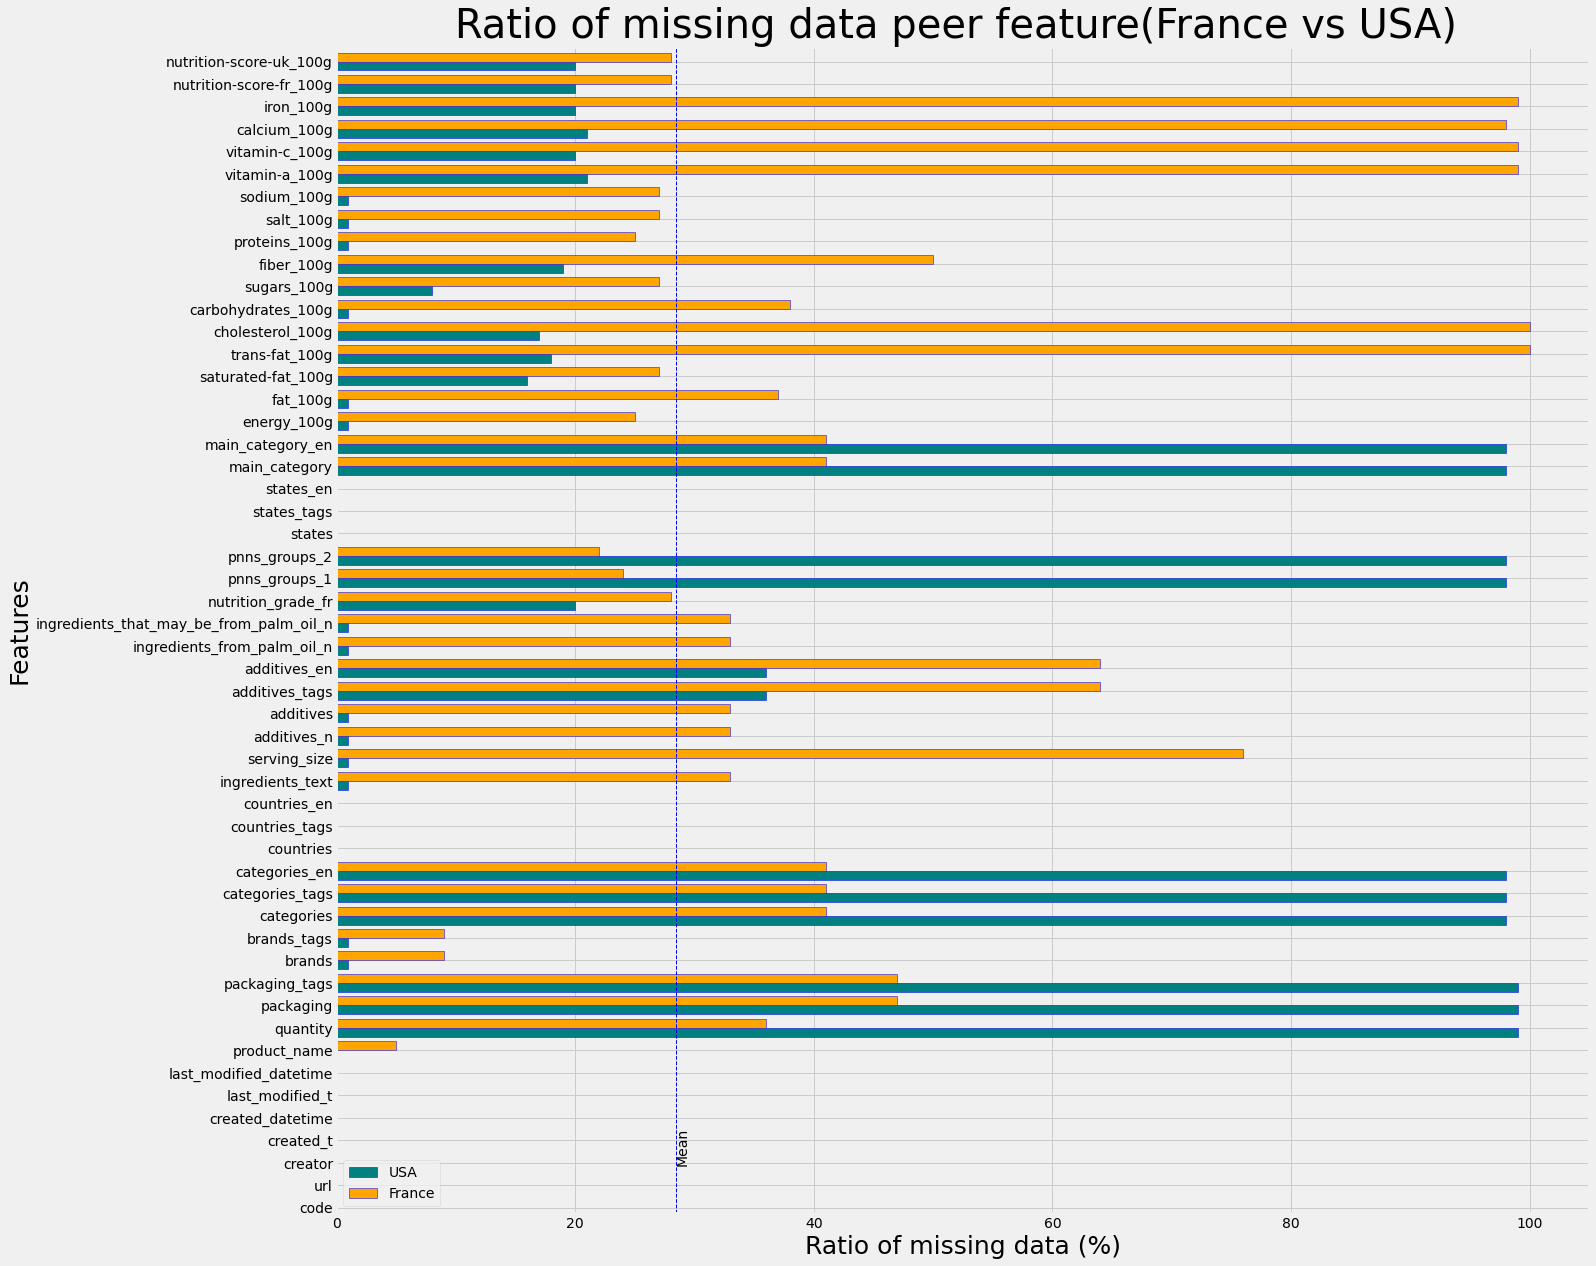

In [14]:

df_usa = df[df['countries_en'].str.contains('United States',na=False)].notnull().sum()
df_usa_null = df[df['countries_en'].str.contains('United States',na=False)].isnull().sum()
df_usa_null_ratio = (df_usa_null/(df_usa+df_usa_null))*100


df_france = df[df['countries_en'].str.contains('France',na=False)].notnull().sum()
df_france_null = df[df['countries_en'].str.contains('France',na=False)].isnull().sum()
df_france_null_ratio = (df_france_null/(df_france+df_france_null))*100

avr = np.mean(((df_usa_null+df_france_null)/(df_france+df_france_null+df_usa+df_usa_null))*100)

fig = plt.figure(figsize = (20,20))

bar_plot_uf = fig.add_subplot(111) 

width = 0.4

df_usa_null_ratio.round().astype(int).plot(kind ='barh', color='teal', edgecolor='b',ax=bar_plot_uf, width=width, position=1, legend = True, label='USA')
df_france_null_ratio.round().astype(int).plot(kind ='barh',color='orange',edgecolor='b', ax=bar_plot_uf, width=width, position=0, legend = True, label='France')
bar_plot_uf.axvline(avr, color='blue',linestyle = '--' ,linewidth=1)
plt.text(avr,2,'Mean',rotation=90)

bar_plot_uf.set_title('Ratio of missing data peer feature(France vs USA) ', fontsize=40)
bar_plot_uf.set_xlabel('Ratio of missing data (%)', fontsize=25)
bar_plot_uf.set_ylabel('Features', fontsize=25)

bar_plot_uf.grid(True)

plt.show()

From the figure we could conclude: 

   * The USA products exhibit more messing data in the categorical features compared to the numerical features.

   * The France products exhibit more messing data in micronutrient $^{1}$ (numerical feature), and certain types macronutrient$^{2}$ with less messing data in the categorical columns compared to the USA

$^{1}$ An essential nutrient, as a trace mineral or vitamin, that is required by an organism in minute amounts. “Definition of Micronutrient | Dictionary.Com.”

$^{2}$ Any of the nutritional components of the diet that are required in relatively large amounts: protein, carbohydrate, fat, and the macrominerals “Definition of Macronutrient | Dictionary.Com.”
***

Which packages often used for food products?

In [15]:

df_count_pack = df.groupby('packaging')['packaging'].count()
df_count_pack_ratio = (df_count_pack/df['packaging'].notnull().sum())*100

bar_plot_pck = df_count_pack_ratio.sort_values().tail(10).plot(kind= 'barh',
                                                               figsize=(20,10),
                                                               edgecolor='black',
                                                               grid=False,
                                                               color= 'teal',
                                                               fontsize=20,
                                                               rot=0,
                                                               alpha = 0.6)

bar_plot_pck.set_title('Top 10 used packaging', fontsize=40)
bar_plot_pck.set_xlabel('Ratio(%)', fontsize=25)
bar_plot_pck.set_ylabel('Packaging', fontsize=25)

bar_plot_pck.grid(True)

plt.show()

***
The date and time columns represent the time that the contribution had been made to the world food facts database and the time of last modification. Those columns will be later converted from dtype Object to `datetimeindex` using the pandas function to_datetime.

In [16]:
df[['last_modified_datetime','created_datetime']].head()

last_modified_datetime      created_datetime
0   2016-09-17T09:18:13Z  2016-09-17T09:17:46Z
1   2017-03-09T14:32:37Z  2017-03-09T14:32:37Z
2   2017-03-09T14:32:37Z  2017-03-09T14:32:37Z
3   2017-03-09T10:35:31Z  2017-03-09T10:35:31Z
4   2017-03-09T10:34:13Z  2017-03-09T10:34:13Z

***

### Numerical columns exploration 
***

What is the number of numerical columns ?

In [17]:
print('The total number of numerical columns = ',df.loc[:, df.dtypes == float].shape[1])

The total number of numerical columns =  20


Let's have statistical description of our numerical columns:

In [18]:
df.loc[:, df.dtypes == float].describe()

additives_n  ingredients_from_palm_oil_n  \
count  283867.000000                283867.000000   
mean        1.876851                     0.023430   
std         2.501022                     0.153094   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        30.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n    energy_100g      fat_100g  \
count                            283867.000000  295367.000000  2.794970e+05   
mean                                  0.059736    1125.453320  5.606587e+04   
std                                   0.280660     936.825952  2.963385e+07   
min                                   0.000000       0.000000  0.000000e+00   
25%                                   0.000000     382.000000  1.000000e-01   
50%                                   0.000000    1092.000000  5.290000e+00   
75%                                   0.000000    1674.000000  2.000000e+01   
max                                   6.000000  231199.000000  1.566667e+10   

       saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
count       263823.000000   143443.000000     144170.000000   
mean             5.092460        0.073487          0.020065   
std              7.965148        1.539417          0.357963   
min              0.000000       -3.570000          0.000000   
25%              0.000000        0.000000          0.000000   
50%              1.790000        0.000000          0.000000   
75%              7.140000        0.000000          0.020000   
max            550.000000      369.000000         95.238000   

       carbohydrates_100g    sugars_100g    fiber_100g  proteins_100g  \
count        2.792200e+05  279186.000000  2.206830e+05   2.941610e+05   
mean         5.614020e+04      15.673428  3.843467e+05   5.326598e+04   
std          2.964854e+07      21.983635  1.805529e+08   2.888578e+07   
min          0.000000e+00     -17.860000 -6.700000e+00  -8.000000e+02   
25%          5.600000e+00       1.200000  0.000000e+00   7.200000e-01   
50%          2.000000e+01       5.400000  1.500000e+00   4.880000e+00   
75%          5.758000e+01      23.330000  3.600000e+00   1.000000e+01   
max          1.566667e+10    3520.000000  8.481815e+10   1.566667e+10   

           salt_100g    sodium_100g  vitamin-a_100g  vitamin-c_100g  \
count  289739.000000  289694.000000   137706.000000   141060.000000   
mean        1.941281       0.764401        0.000398        0.023394   
std       120.545973      47.462729        0.073239        2.234928   
min         0.000000       0.000000       -0.000340       -0.002100   
25%         0.060000       0.023622        0.000000        0.000000   
50%         0.558800       0.220000        0.000000        0.000000   
75%         1.356360       0.534000        0.000107        0.003800   
max     64312.800000   25320.000000       26.700000      716.981100   

        calcium_100g      iron_100g  nutrition-score-fr_100g  \
count  141517.000000  140660.000000            254856.000000   
mean        0.127284       0.003791                 9.166137   
std         3.349236       0.216565                 8.999870   
min         0.000000      -0.000260               -15.000000   
25%         0.000000       0.000000                 1.000000   
50%         0.036000       0.001010                10.000000   
75%         0.107000       0.002400                16.000000   
max       694.737000      50.000000                40.000000   

       nutrition-score-uk_100g  
count            254856.000000  
mean                  8.980656  
std                   9.151757  
min                 -15.000000  
25%                   1.000000  
50%                   9.000000  
75%                  16.000000  
max                  40.000000

From the statistics we have: 

* Distinct features have different amount of non null data.

* The nutrition score ‘uk’ and ‘fr’ statistics are similar, which may indicates duplication.

* There are outlier values in most of the columns by looking up at the mean and standard deviation, and for quantities that are contained between 0 and 100.
***

***
By tacking different samples of products and compare the products we noticed that there is mixing between energy with different unites (Kj and Kcal).
***

## Cleaning the data
### Categorical data

***
Let's work on copy of the initial dataframe.

In [19]:
df_c = df.copy()

***
After exploring the categorical columns, we dropped the following column because:

* Duplicated information in another column.

* High number of messing data.

In [20]:
df_c.drop(df_c[['creator', 'url','last_modified_t','serving_size','created_t','brands_tags','categories','categories_tags',
              'countries_tags','countries','serving_size','quantity','additives','states','main_category_en','categories_en',
               'states','states_tags','states_en', 'additives_tags','pnns_groups_2','packaging_tags','main_category']], axis = 1, inplace = True)

***
We will remove the products that have unknown categories and sub categories

In [21]:
df_c.drop(df_c[df_c['pnns_groups_1'] == 'unknown'].index, axis=0,inplace=True )

***
Convert the duplicated categories names

In [22]:
df_c['pnns_groups_1']=df_c['pnns_groups_1'].str.replace('fruits-and-vegetables','Fruits and vegetables')
df_c['pnns_groups_1']=df_c['pnns_groups_1'].str.replace('cereals-and-potatoes','Cereals and potatoes')
df_c['pnns_groups_1']=df_c['pnns_groups_1'].str.replace('salty-snacks','Salty snacks')
df_c['pnns_groups_1']=df_c['pnns_groups_1'].str.replace('sugary-snacks','Sugary snacks')

***
Change the name of the pnns_groups_1 to categories and pnns_group_2 to sub_categories 

In [23]:
df_c.rename(columns={'pnns_groups_1': 'categories'},inplace=True)

***
Remove the duplicated data point based on theire product name, brand and packaging

In [24]:
df_c.drop_duplicates(('product_name','brands'),inplace=True)

***
### Numerical columns

We will execute the following tasks to clean the numerical columns:

* 1. Remove the duplicated columns. and other columns and keep major food characteristics columns: Energy, protein, fat, carbohydrate, salt.
* 2. Fill the missing data from the numerical columns with zero.
* 4. Exclude the products that have values higher than 100 and lower than 0 involving the columns that represent a quantity between 0 and 100.
* 5. Exclude the outliers using z score. 
* 6. Exclude the products that have messing data.

In [25]:
df_c.loc[:, df_c.dtypes == float].describe()

additives_n  ingredients_from_palm_oil_n  \
count  230927.000000                230927.000000   
mean        1.921252                     0.018655   
std         2.534408                     0.137117   
min         0.000000                     0.000000   
25%         0.000000                     0.000000   
50%         1.000000                     0.000000   
75%         3.000000                     0.000000   
max        30.000000                     2.000000   

       ingredients_that_may_be_from_palm_oil_n    energy_100g      fat_100g  \
count                            230927.000000  240246.000000  2.259980e+05   
mean                                  0.055528    1121.382895  6.933489e+04   
std                                   0.270996     954.634239  3.295523e+07   
min                                   0.000000       0.000000  0.000000e+00   
25%                                   0.000000     368.000000  0.000000e+00   
50%                                   0.000000    1088.000000  4.900000e+00   
75%                                   0.000000    1674.000000  2.000000e+01   
max                                   5.000000  231199.000000  1.566667e+10   

       saturated-fat_100g  trans-fat_100g  cholesterol_100g  \
count       213034.000000   130092.000000     130865.000000   
mean             5.125003        0.072798          0.019748   
std              8.179947        1.593453          0.320888   
min              0.000000       -3.570000          0.000000   
25%              0.000000        0.000000          0.000000   
50%              1.790000        0.000000          0.000000   
75%              7.140000        0.000000          0.020000   
max            550.000000      369.000000         95.238000   

       carbohydrates_100g    sugars_100g     fiber_100g  proteins_100g  \
count        2.257550e+05  226683.000000  183843.000000   2.393120e+05   
mean         6.942850e+04      15.826281       2.845318   6.547248e+04   
std          3.297296e+07      22.298098      13.524760   3.202538e+07   
min          0.000000e+00     -17.860000      -6.700000  -8.000000e+02   
25%          5.730000e+00       1.300000       0.000000   6.000000e-01   
50%          2.000000e+01       5.600000       1.500000   4.700000e+00   
75%          5.800000e+01      23.530000       3.600000   1.000000e+01   
max          1.566667e+10    3520.000000    5380.000000   1.566667e+10   

           salt_100g    sodium_100g  vitamin-a_100g  vitamin-c_100g  \
count  236018.000000  235984.000000   125207.000000   128103.000000   
mean        1.981447       0.780209        0.000207        0.015837   
std       133.308022      52.487253        0.014338        1.080457   
min         0.000000       0.000000       -0.000340       -0.002100   
25%         0.050800       0.020000        0.000000        0.000000   
50%         0.561340       0.222000        0.000000        0.000000   
75%         1.361440       0.536000        0.000107        0.003600   
max     64312.800000   25320.000000        5.000000      370.370400   

        calcium_100g      iron_100g  nutrition-score-fr_100g  \
count  128265.000000  127626.000000            205600.000000   
mean        0.122802       0.003191                 9.160375   
std         2.924103       0.166312                 9.041427   
min         0.000000      -0.000260               -15.000000   
25%         0.000000       0.000000                 1.000000   
50%         0.035000       0.001010                10.000000   
75%         0.105000       0.002400                16.000000   
max       613.636000      47.058820                40.000000   

       nutrition-score-uk_100g  
count            205600.000000  
mean                  8.948196  
std                   9.217734  
min                 -15.000000  
25%                   1.000000  
50%                   9.000000  
75%                  16.000000  
max                  40.000000

***
Remove the duplicated columns. and other columns and keep major food characteristics columns: Energy, protein, fat, carbohydrate, salt...

In [26]:
df_c.drop(['nutrition-score-uk_100g','vitamin-c_100g','calcium_100g'
          ,'cholesterol_100g','sodium_100g','vitamin-a_100g','trans-fat_100g',
          'calcium_100g','iron_100g','ingredients_that_may_be_from_palm_oil_n'], axis=1, inplace=True)

***
Exclude the products that have values higher than 100 and lower than 0 involving the columns that represent a quantity between 0 and 100.

In [27]:
df_numeric= df_c.loc[:, df_c.dtypes == float]
df_numeric_filter = (df_numeric.iloc[:,3:10] < 0) | (df_numeric.iloc[:,3:10] > 100) 
outliers = df_c.loc[df_numeric_filter.any(1), :]
df_c.drop(outliers.index, axis=0, inplace=True)

***
The energy depends on the contribution of other macronutrients. The oxidation of 1 g of dietary carbohydrate and 1 g of dietary protein (which is oxidized to urea) each yield approximately 4 kcal, whereas oxidation of 1 g of dietary fat yields approximately 9 kcal. 

Energy (Kcaj) = [Protein (g) × 17] + [Fats (g) × 37] + [Av. Carbohydrates (g) × 17] $^1$

From this formula, we could fill different missing data for macronutrients and energy convert values from Kj to Kcal.(We will assume that the macronutrients entries are correct) 

$^1$National Research Council (US) Committee on Diet and Health, Calories: Total Macronutrient Intake, Energy Expenditure, and Net Energy Stores, Diet and Health: Implications for Reducing Chronic Disease Risk (National Academies Press (US), 1989), https://www.ncbi.nlm.nih.gov/books/NBK218769/.

In [28]:
df_ess = df_c.loc[df_c['categories'] != 'Beverages'][['energy_100g','carbohydrates_100g','fat_100g','proteins_100g']].copy()
df_ess.dropna(axis = 0,how='all', inplace= True)
df_c.loc[df_ess.index, 'energy_100g'] = df_ess['carbohydrates_100g'] * 17 + df_ess['fat_100g' ] * 37 + df_ess['proteins_100g'] * 17

***
Here we have taken the same code from the course to boxplots with a small twich to identifie the outliers:

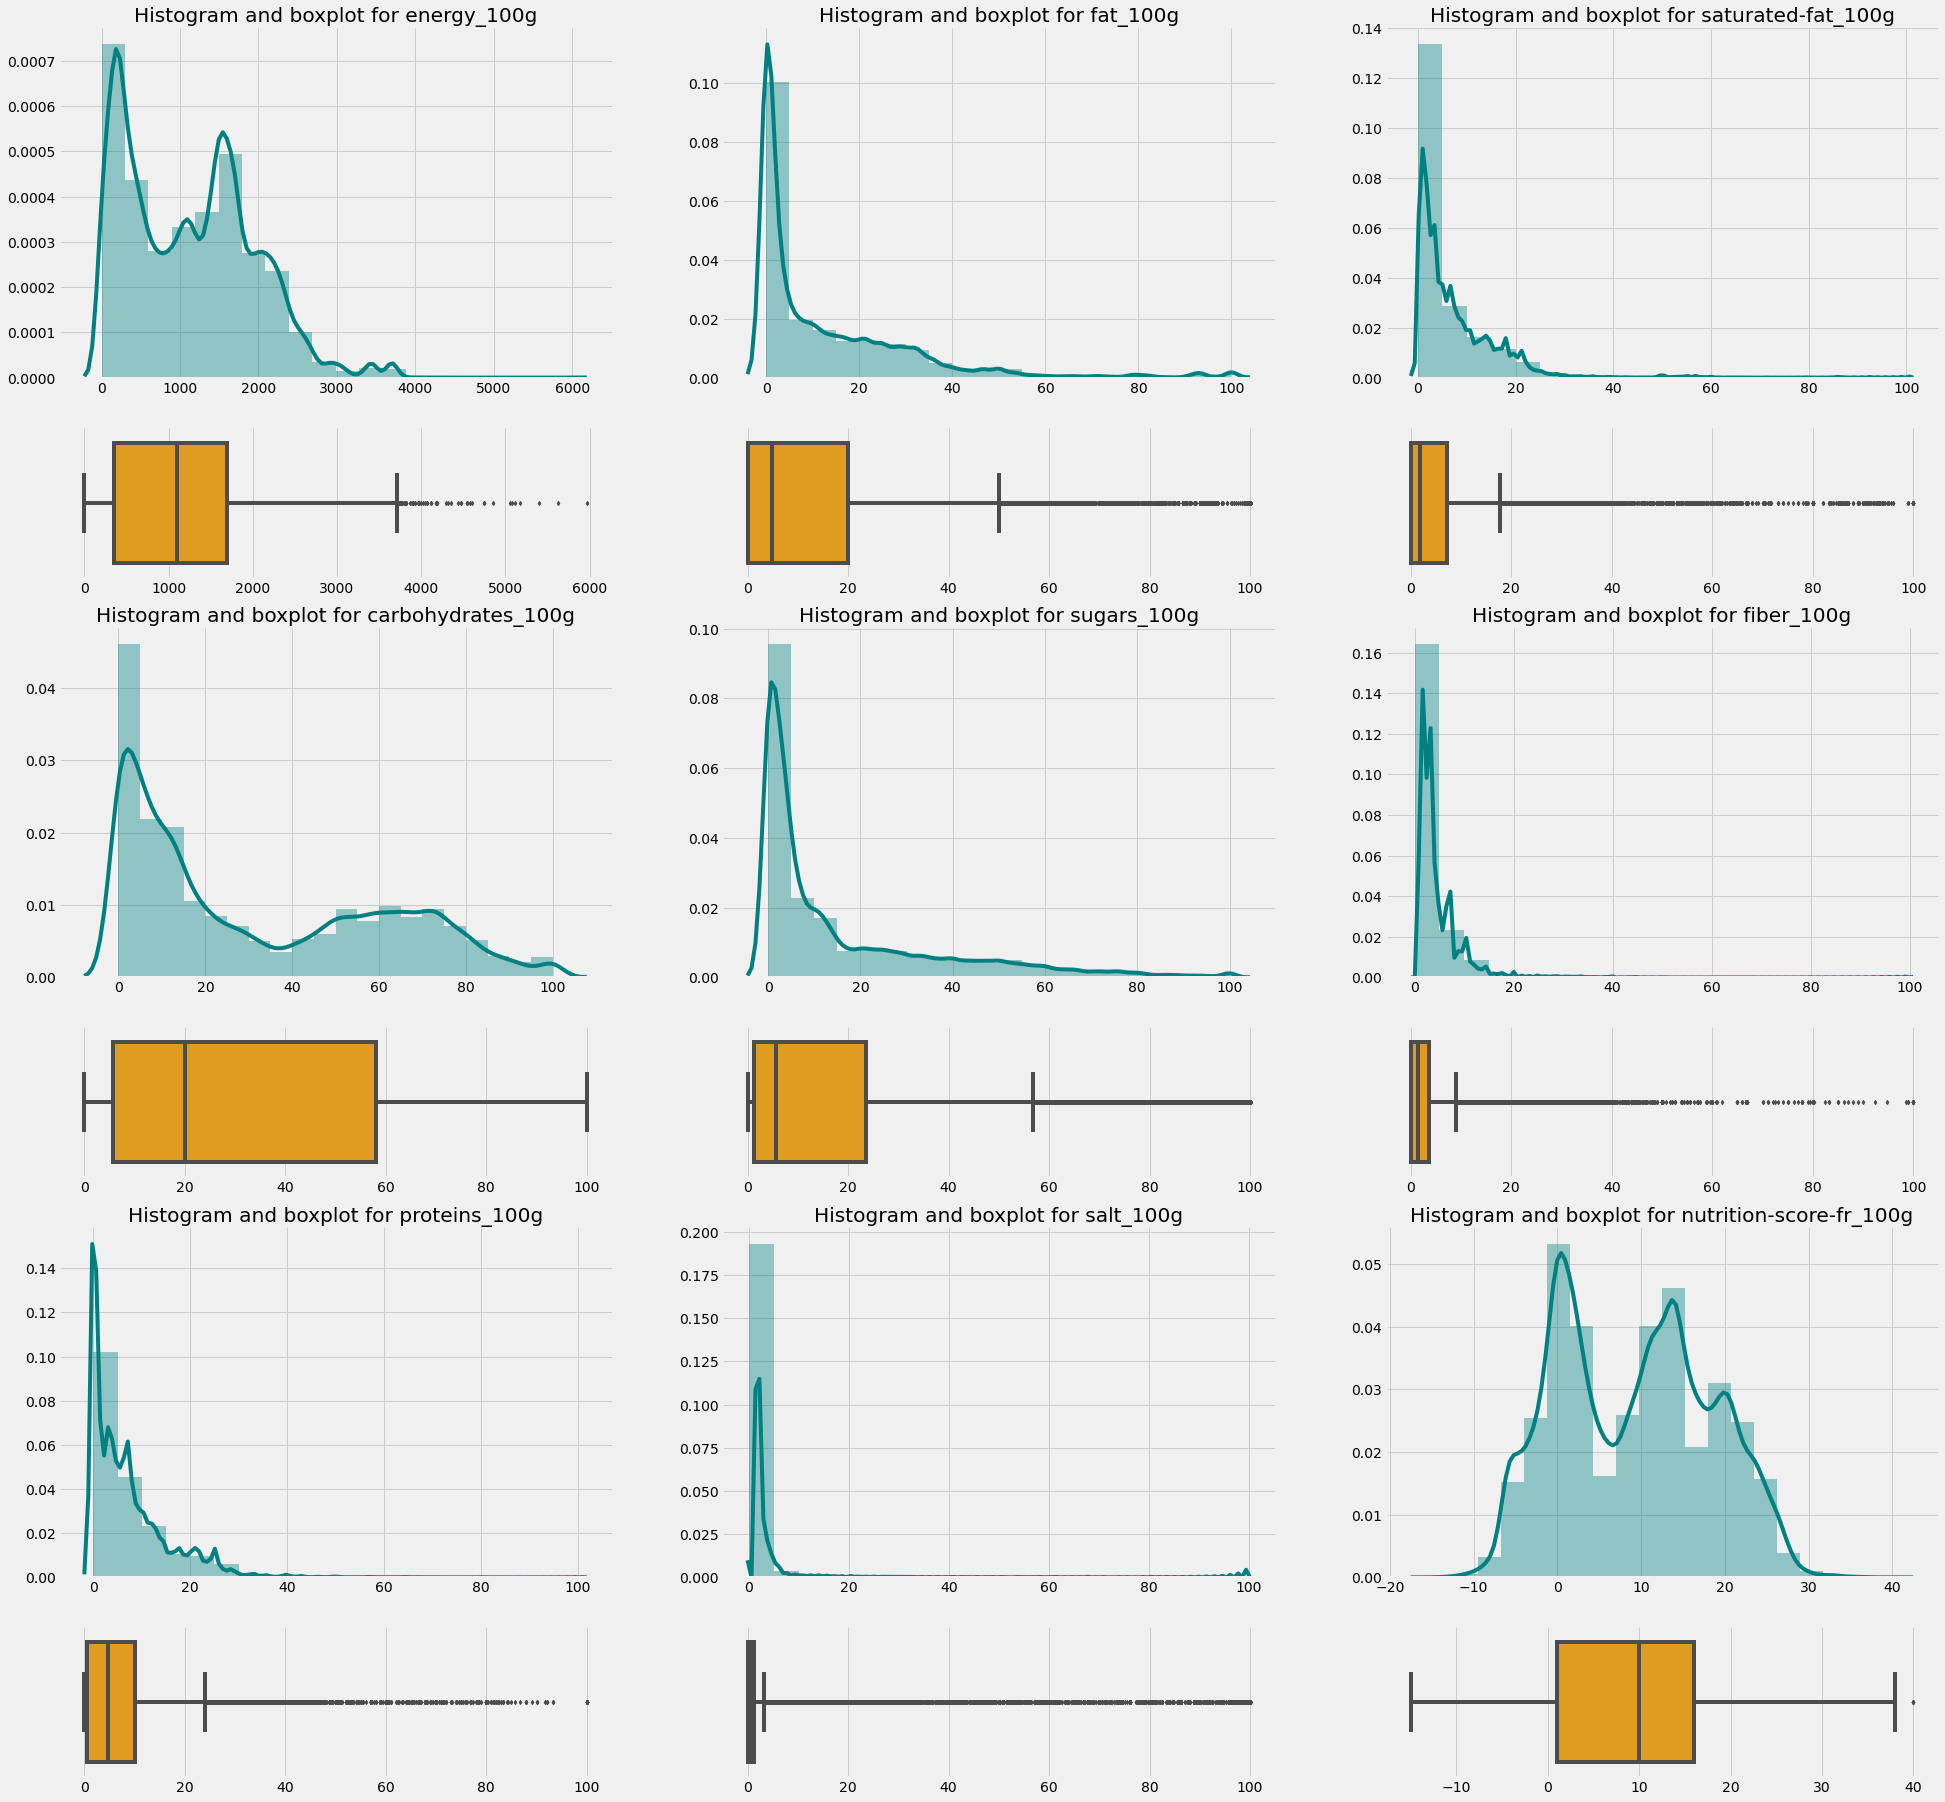

In [29]:

fig, axes = plt.subplots(
    6, 3, gridspec_kw={"height_ratios": (0.7, 0.3,0.7, 0.3,0.7, 0.3)}, figsize=(30, 30)
)

i=0
for (feat, plot_col) in zip(
    df_c.loc[:, df_c.dtypes == float].iloc[:,2:12].columns, [0, 1, 2, 0, 1, 2, 0, 1, 2]  # pairing feature with column in plot
    ):
        k=2*i
        sns.distplot(df_c[df_c[feat].notnull()][feat], bins=20, ax=axes[k, plot_col],color= 'teal',norm_hist=True)
        axes[k, plot_col].set_title("Histogram and boxplot for {}".format(feat))
        sns.despine(ax=axes[k, plot_col])
   
        sns.boxplot(df_c[feat], ax=axes[k+1, plot_col], fliersize=3, color = 'orange')
        axes[k+1, plot_col].set(yticks=[])
        sns.despine(ax=axes[k+1, plot_col], left=True)
        
        if plot_col == 2:
            i+=1
    
for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

***
Remove the outliers using z score. 

In [30]:
df_numeric = df_c.loc[:, df_c.dtypes == float]
Filter = np.abs(df_numeric.iloc[:,2:10] - df_numeric.iloc[:,2:10].mean()) > (2 * df_numeric.iloc[:,2:10].std())
outliers = df_c.loc[Filter.any(axis=1), :]
df_c.drop(outliers.index, axis=0, inplace=True)

***
We look again at the data distribution after removing outliers.

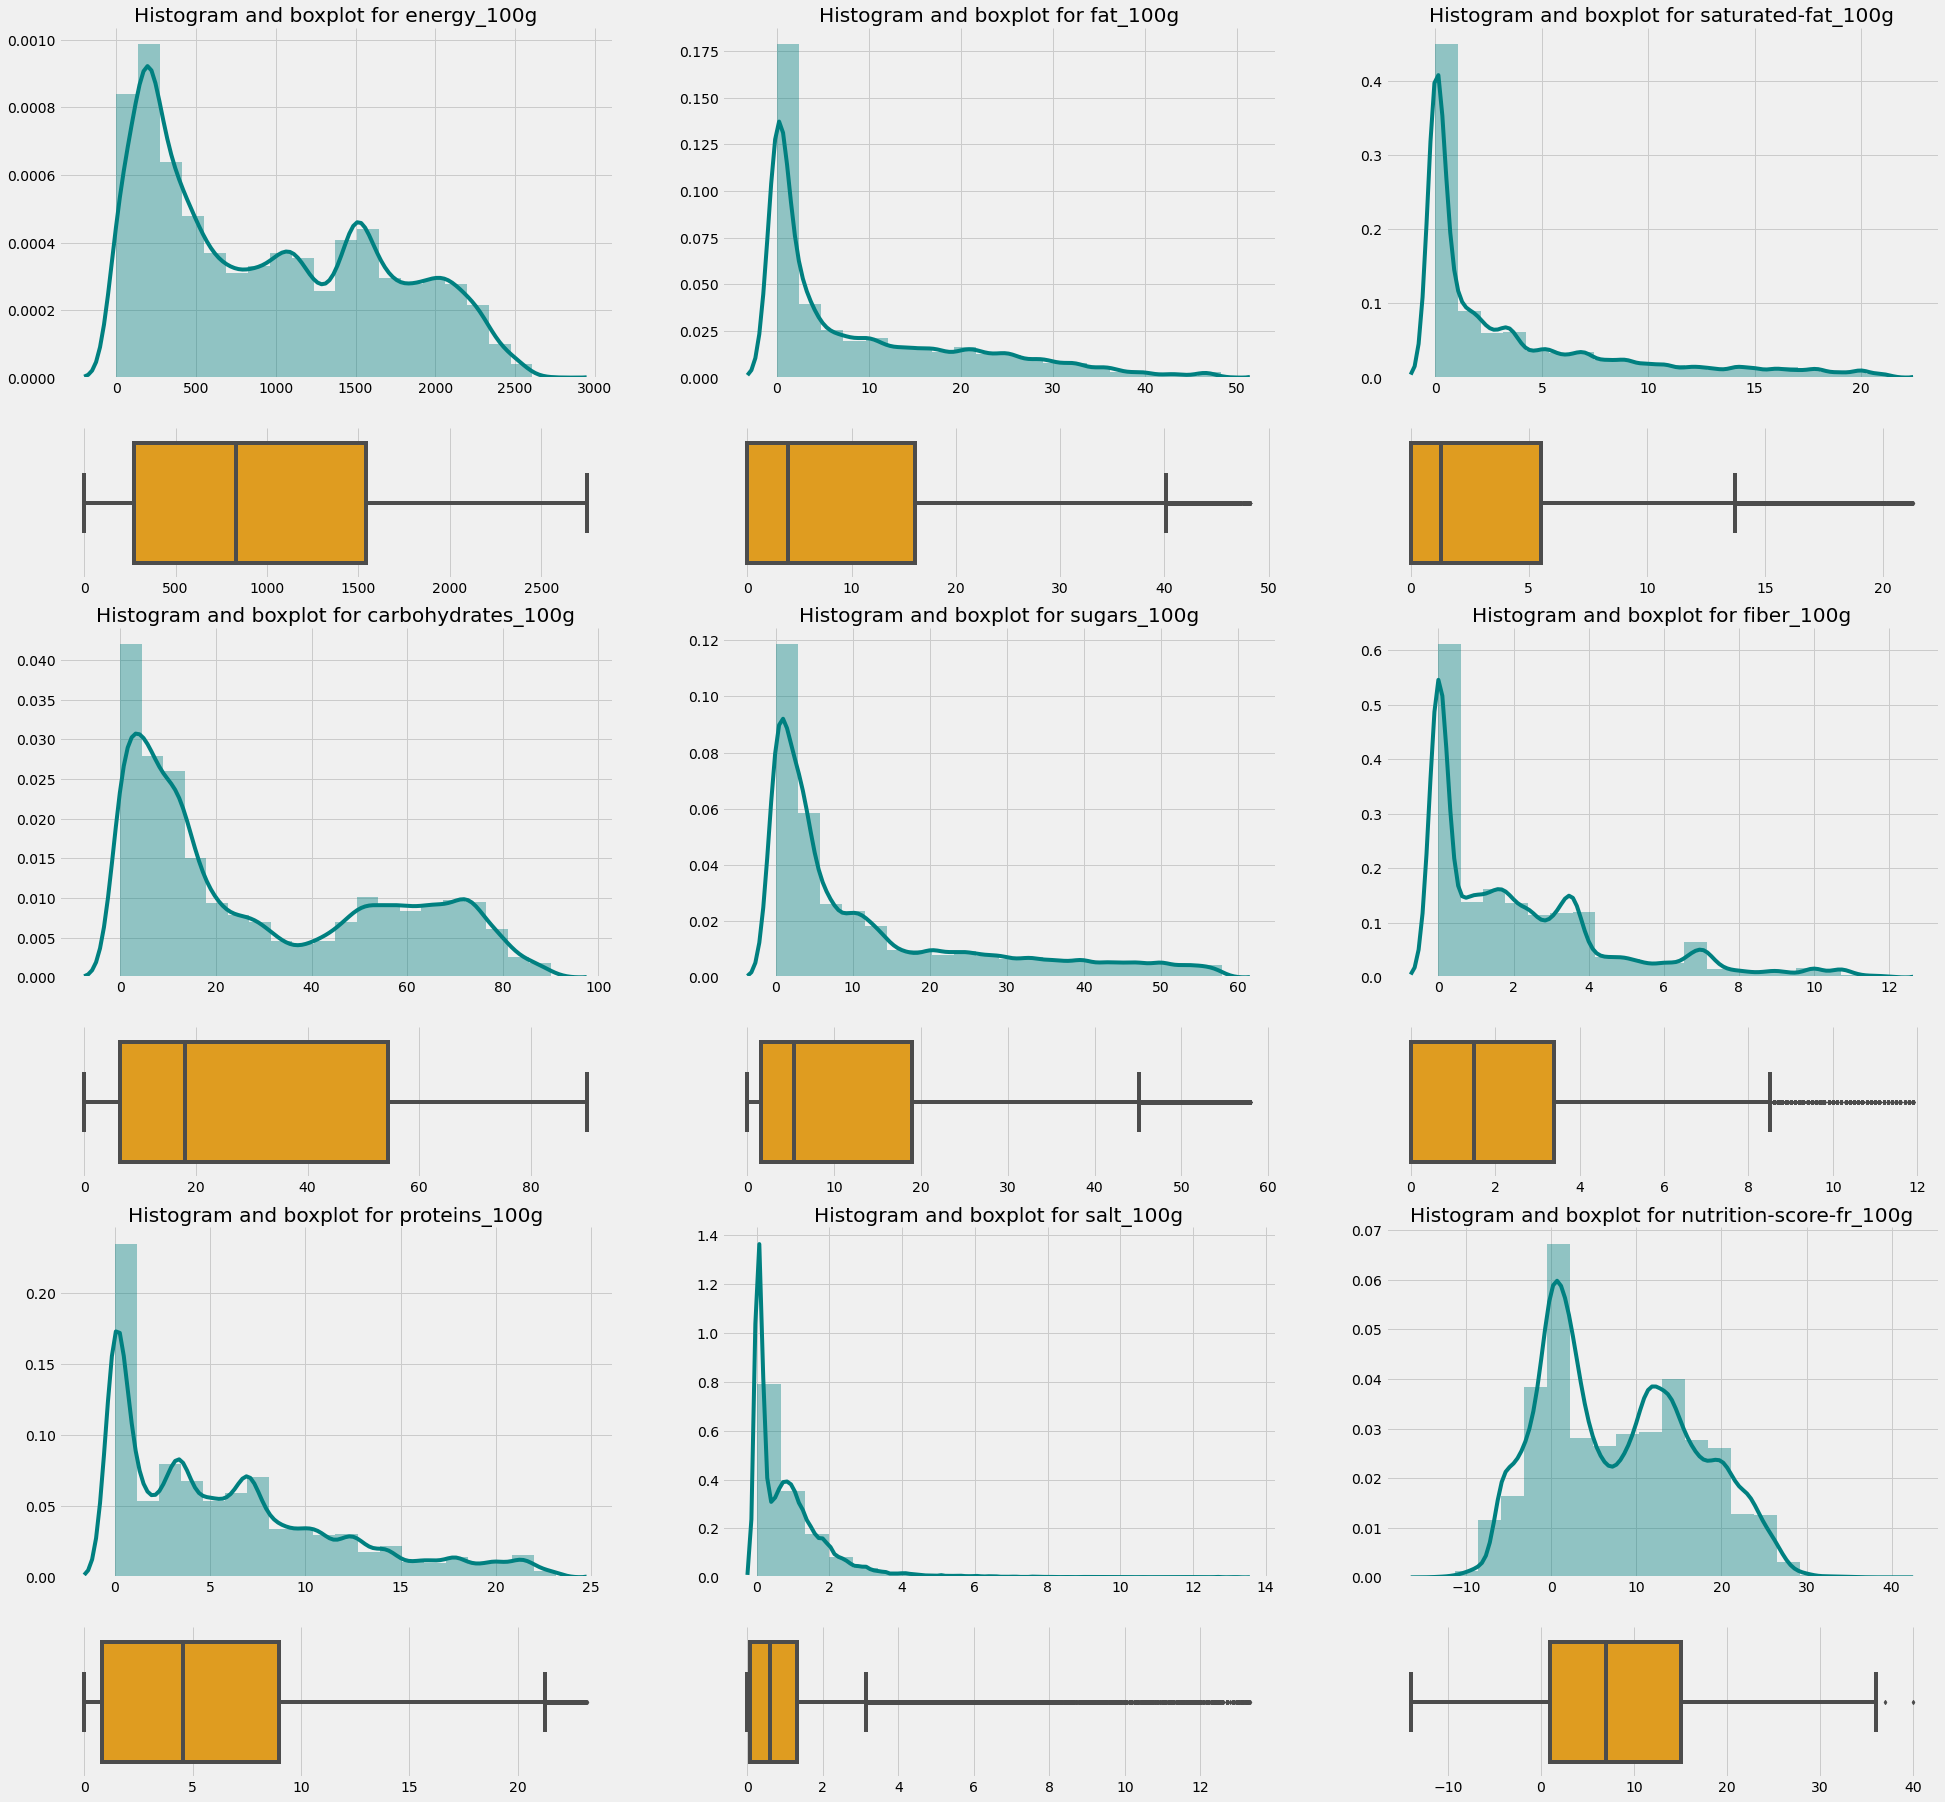

In [31]:

fig, axes = plt.subplots(
    6, 3, gridspec_kw={"height_ratios": (0.7, 0.3,0.7, 0.3,0.7, 0.3)}, figsize=(30, 30)
)

i=0
for (feat, plot_col) in zip(
    df_c.loc[:, df_c.dtypes == float].iloc[:,2:11].columns, [0, 1, 2, 0, 1, 2, 0, 1, 2]  # pairing feature with column in plot
    ):
        k=2*i
        sns.distplot(df_c[df_c[feat].notnull()][feat], bins=20, ax=axes[k, plot_col],color= 'teal',norm_hist=True)
        axes[k, plot_col].set_title("Histogram and boxplot for {}".format(feat))
        sns.despine(ax=axes[k, plot_col])
   
        sns.boxplot(df_c[feat], ax=axes[k+1, plot_col], fliersize=3, color = 'orange')
        axes[k+1, plot_col].set(yticks=[])
        sns.despine(ax=axes[k+1, plot_col], left=True)
        
        if plot_col == 2:
            i+=1
    
for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

It looks like they’re still outliers but in food general, we could find food products we those extreme values of unique features.
***

In [32]:
df_c.shape

(228651, 22)

***
We check the number of messing data at each column. We could notice that the additives columns almost one third of the data are missing there for great amout of data would be drouped 

In [33]:
df_c.isnull().sum().sort_values()

last_modified_datetime              0
created_datetime                    2
code                                4
countries_en                      139
product_name                      575
brands                          10769
proteins_100g                   37945
salt_100g                       40715
ingredients_text                42857
ingredients_from_palm_oil_n     42861
additives_n                     42861
sugars_100g                     46148
fat_100g                        48713
carbohydrates_100g              48855
energy_100g                     49397
saturated-fat_100g              57934
nutrition_grade_fr              62140
nutrition-score-fr_100g         62140
fiber_100g                      79176
additives_en                   110852
categories                     158413
packaging                      164754
dtype: int64

***
Finally, we will drop the rows that have missing data.

In [34]:
df_c.shape

(228651, 22)

In [35]:
df_c.dropna(axis=0).shape

(15735, 22)

<mark> I'm not running the cell below, in order to keep all the rows!

***
We have left 12 762 data points and 22 features for a single country. This amount of data should be enough to allow us to conduct our study.

In [36]:
df_c.shape

(228651, 22)

***
# __B. In-depth analysis__

The food products composition, the methods of calculation of nutrition score and the relationships between them are well known, it’s hard to come up with a question to add knowledge from analyzing this data. Nevertheless, we will try to investigate the use of palm oil in food products.

It knows that palm oil is a highly used organic oil because of its yield and price. However, it imposes health and environmental challenges because of its composition(45% saturated fat) and its cultivation methods. To investigate the use of palm oil, let's answer the following questions.

* What is the product category that is the most susceptible to using palm oil?
* Does the use of palm oil in food products implies high use of additives?
* Does the food products containing palm oil are susceptible to using high over exposed risky additives compared to products without palm oil?

## Question 1 :

***
Let's separate the products with and without palm oil:

In [37]:
df_palm_oil  = df_c.loc[df_c['ingredients_from_palm_oil_n'] !=  0 ]
df_no_palm_oil  = df_c.loc[df_c['ingredients_from_palm_oil_n'] ==  0]

***
For the products that use palm oil, we have 1558 products. The rest are products without palm oil.

In [38]:
df_palm_oil.shape[0]

46567

***
Here we did take a sample from the products without palm oil with the same size of products with palm oil and calculated its correlation with the population to see if the sample represents the population.

In [39]:
df_no_palm_oil.sample(df_palm_oil.shape[0]).corrwith(df_no_palm_oil)

additives_n                    1.0
ingredients_from_palm_oil_n    NaN
energy_100g                    1.0
fat_100g                       1.0
saturated-fat_100g             1.0
carbohydrates_100g             1.0
sugars_100g                    1.0
fiber_100g                     1.0
proteins_100g                  1.0
salt_100g                      1.0
nutrition-score-fr_100g        1.0
dtype: float64

We see every numerical column correlate perfectly. Therefore, the sample represents the products without palm oil.

In [40]:
df_no_palm_oil = df_no_palm_oil.sample(df_palm_oil.shape[0])

***
Now we will plot the number of products of each category and for each group of products (with or without palm oil)

In [41]:
x_1 = df_palm_oil.groupby('categories').count().code
x_2 = df_no_palm_oil.groupby('categories').count().code


fig = plt.figure(figsize = (20,8))

ax = fig.add_subplot(111) 

width = 0.2

x_1.plot.bar(color='teal', ax=ax, width=width, position=1, legend = True, label='Product with palm oil')
x_2.plot.bar(color='orange', ax=ax, width=width, position=0, legend = True, label='Products without palm oil')

for i, v in enumerate(x_1):
    ax.text( i- 0.18, v + 3, str(v), color='blue', fontweight='bold')
for i, v in enumerate(x_2):
    ax.text( i, v + 3, str(v), color='blue', fontweight='bold')
    
ax.set_ylabel('Mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha='center')

plt.show()

From the figure, we can see that the product category the uses the most palm oil is the sugary snacks category that represents more than 50% of all products that contain palm oil as an ingredient. We will see later that this category, represents a great portion of low graded products.
***

## Question 2 :
To answer this question, wee will plot the number.

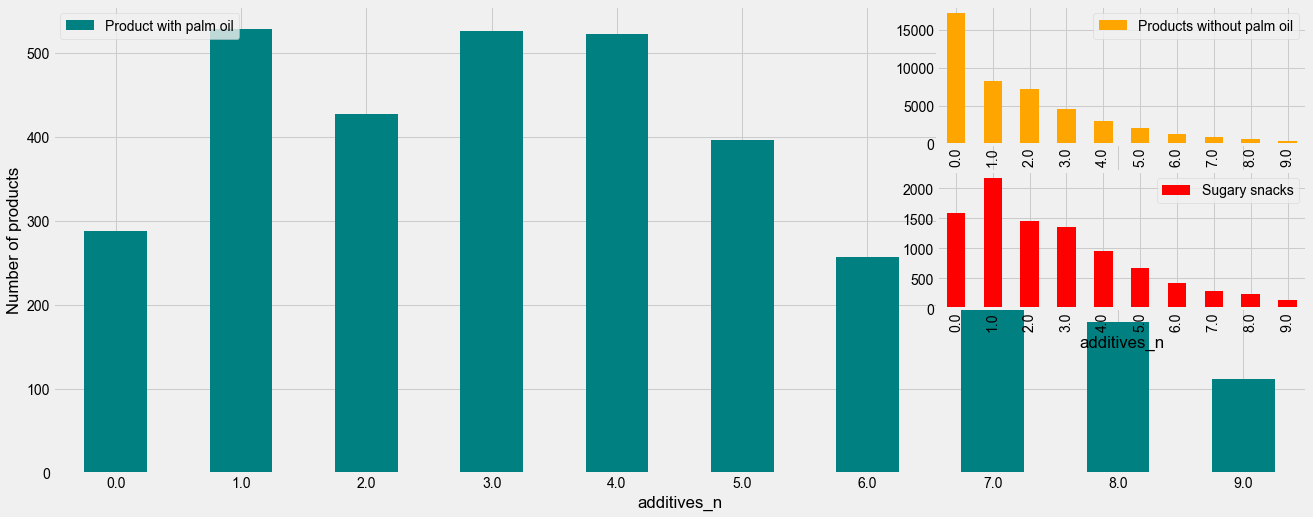

In [42]:
x_1 = df_palm_oil.groupby('additives_n').count().head(10).code
x_2 = df_no_palm_oil.groupby('additives_n').count().head(10).code
x_3 = df_c.loc[df_c['categories']=='Sugary snacks'].groupby('additives_n').count().head(10).code

fig = plt.figure(figsize = (20,8))

ax = fig.add_subplot(111) 
ax2 = fig.add_subplot(333) 
ax3 = fig.add_subplot(336) 
width = 0.5

x_1.plot.bar(color='teal', ax=ax, width=width, legend = True, label='Product with palm oil')
x_2.plot.bar(color='orange', ax=ax2, width=width, legend = True, label='Products without palm oil')
x_3.plot.bar(color='red', ax=ax3, width=width, legend = True, label='Sugary snacks')

ax.set_ylabel('Number of products')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha='center')
ax.legend(loc='upper left')

sns.set()

From the products without palm oil, we see that as the number of products decreases as the number of additives decreases, where else for the products with palm oil we see that as the number of additives increases the number of products increases until the peak at 4 where it follows the same behavior as the products without palm oil. Also, we could see that the distribution of the number of additives for products with palm oil follows the distribution of additives for sugary snacks products. Hence, no conclusion could be made of the relationship between palm oil and the number of additives.
***

## Question 3:
The list of over exposure additives had been extracted from the open food facts website. From each group of products we extracted the number of additves 

<mark> Just emphasizing below how the choice of NaNs handling will impact your results </mark>

In [43]:
over_exposure_add = ['E202', 'E450','E407','E250','E150c','E211','E341','E621','E200',
                     'E452','E340','E223','E338','E451','E150a','E220','E252','E212',
                     'E339','E150d','E491','E222','E251','E407a','E492','E221','E473',
                     'E343','E210','E482','E228','E155','E243','E226','E494','E459',
                     'E493','E213']

print("Considering NaNs means no additive")
print(df_palm_oil.additives_en.fillna("").astype(str).str.contains("|".join(over_exposure_add)).mean() * 100) 

print("Removing row when additives is NaN")
print(df_palm_oil.additives_en.dropna().astype(str).str.contains("|".join(over_exposure_add)).mean() * 100)

Considering NaNs means no additive
3.2727038460712525
Removing row when additives is NaN
44.587478057343475


* From the results above we see that more than 50% of the products contain over-exposure additives, but we notice a small difference between products with or without palm oil. Hence, we can say that the use of palm oil in food products does not accompany the use of high exposer additives compared to the products without palm oil.

# __C. Text data__
What are five most common ingredients in the food products available in our dataset? 

In [44]:
df_col = df_c[['ingredients_text']] #Assign the ingredient text column to df_col

In [45]:
list(df_col.loc[:,'ingredients_text'].head()) # Consult the construction of the column and identifies the repetitive patterns for cleaning

[nan,
 'Peanuts, wheat flour, sugar, rice flour, tapioca starch, salt, leavening (ammonium bicarbonate, baking soda), soy sauce (water, soybeans, wheat, salt), potato starch.',
 'Organic polenta',
 'Rolled oats, grape concentrate, expeller pressed canola oil, sunflower seeds, almonds, walnuts oat bran, sesame seeds, cashews, natural vitamin e.',
 'Organic long grain white rice']

In [46]:
i=0

while i<= 3: #
    replace_list = ['\•', '\s*?\,\s*','\s*?\;\s*'] # Patterns to be replaced
    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('|'.join(replace_list),',',regex=True).str.strip()

    replace1_list = ['\.']
    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('|'.join(replace1_list),'s',regex=True).str.strip()

    remove_list = [r"\s*?\([^()]*\)\s*", r'_' , r'\d.*\%', '\.' , r'\w*\s*?\:', r'\s\·\s','\'\s','\`'] # Patterns to be replaced
    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('|'.join(remove_list),'',regex=True).str.strip()

    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('arômes','arôme',regex=True).str.strip()
    
    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('arôme naturel','arôme',regex=True).str.strip()
    
    df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.replace('arôme naturels','arôme',regex=True).str.strip()
    
    i+=1

/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [47]:
df_col.loc[:,'ingredients_text'] = df_col.loc[:,'ingredients_text'].str.lower().copy() # convert the character to lower case 
df_col.loc[:,'ingredients_text'] = df_col['ingredients_text'].str.title() # Convert the words to title format

In [48]:
df_col.loc[:,'ingredients_text'] = df_col.loc[:,'ingredients_text'].astype(str).apply(lambda i: i.split(',')) # creating a list of ingredients

In [49]:
list(df_col.loc[:,'ingredients_text'].head()) # consult how our column is formated 

[['nan'],
 ['Peanuts',
  'Wheat Flour',
  'Sugar',
  'Rice Flour',
  'Tapioca Starch',
  'Salt',
  'Leavening',
  'Soy Sauce',
  'Potato Starchs'],
 ['Organic Polenta'],
 ['Rolled Oats',
  'Grape Concentrate',
  'Expeller Pressed Canola Oil',
  'Sunflower Seeds',
  'Almonds',
  'Walnuts Oat Bran',
  'Sesame Seeds',
  'Cashews',
  'Natural Vitamin Es'],
 ['Organic Long Grain White Rice']]

In [50]:
df_col = df_col.explode('ingredients_text') # Finally we transform our list to row 
df_col.head()

ingredients_text
0              nan
2          Peanuts
2      Wheat Flour
2            Sugar
2       Rice Flour

Finally, print the top 5 used ingredient and their percentages with respect to their use in the products available in our dataset. 

<mark> Top ingredients changed now

In [51]:
top15 = df_col.pivot_table(index=['ingredients_text'], aggfunc='size').sort_values(ascending= False).head((15))

In [52]:
top15.rename({"Sel": "Salt", "Eau": "Water", "Sucre": "Sugar"}).reset_index().groupby("ingredients_text")[0].sum().sort_values(ascending=False).to_frame("count").drop("nan")

count
ingredients_text               
Salt                      61428
Water                     55058
Sugar                     53951
Citric Acid               16543
Arôme                     12616
Corn Syrup                11233
Dextrose                   9787
Natural Flavor             8781
High Fructose Corn Syrup   8693
Spices                     8486
Natural Flavors            8279

# __D. Time-series analysis__

Convert the times columns to datetimeindex

<mark> Pay attention to the `errors="coerce"` argument, to force casting to datetimes </mark>

In [53]:
df_c['created_datetime'] = pd.to_datetime(df_c['created_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors="coerce")
df_c['last_modified_datetime'] = pd.to_datetime(df_c['last_modified_datetime'], format='%Y-%m-%dT%H:%M:%SZ', errors="coerce")

Calculate the average periode of product modifications for all products. 

In [54]:
df_time = df_c [['created_datetime','last_modified_datetime']]
df_time_dif =  df_time.loc[:,'last_modified_datetime']-df_time.loc[:,'created_datetime']
df_time_mean = df_time_dif.mean()
df_time_mean

Timedelta('115 days 16:16:15.484117440')

Now we plot the number of products that had been created each month. Here we used `resample` method sample our data on a frequencyof one month.  

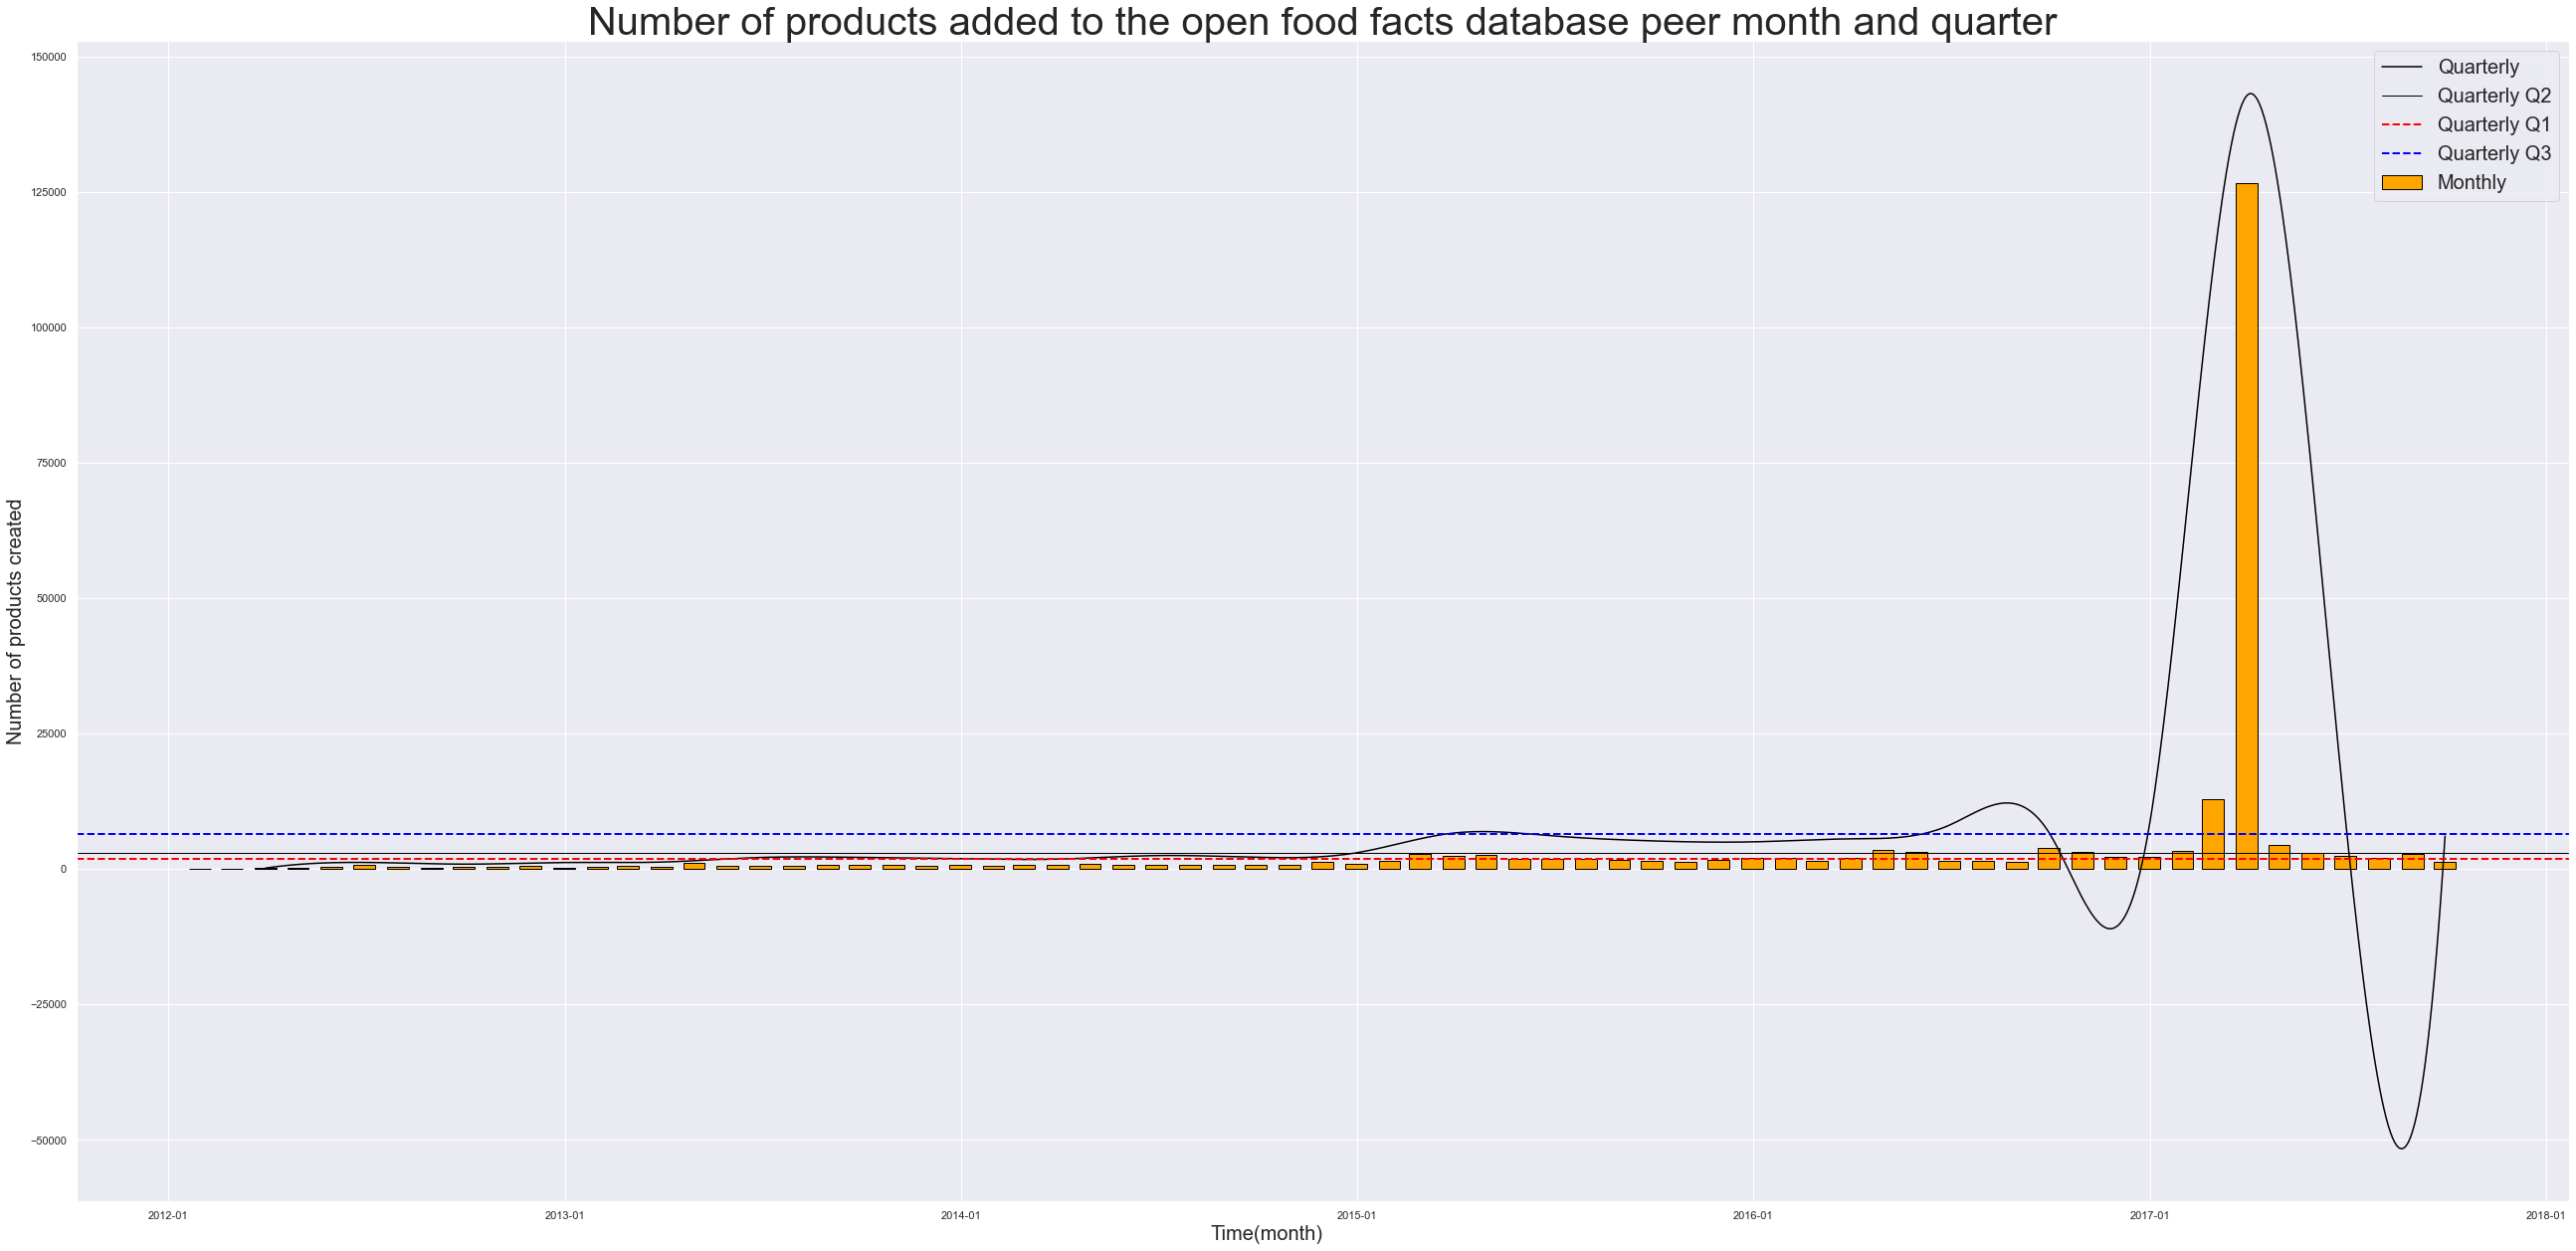

In [55]:
# Resample the data with monthlya and quarterly frequency 
products_created_M = df_c.resample('M', on='created_datetime')['created_datetime'].count()
products_created = df_c.resample('Q', on='created_datetime')['created_datetime'].count()

#plot configuration 
date = products_created.keys()
value = products_created.values
date_matp = mdates.date2num(date)

date_matp_exp = np.linspace(date_matp.min(), date_matp.max(), 1000) 
spline = make_interp_spline(date_matp, value, k=3)
value_matp_exp = spline(date_matp_exp)

#plot 

fig, bar_plot_time = plt.subplots(figsize=(40, 20))

bar_plot_time.bar(products_created_M.index, products_created_M.values, width=20, align='center',color='orange', edgecolor= 'black', label ='Monthly')
bar_plot_time.plot(date_matp_exp, value_matp_exp, color='black', label= 'Quarterly')

bar_plot_time.axhline(products_created.quantile(q=0.5), color='black',linestyle = '-' ,linewidth=1, label= 'Quarterly Q2')
bar_plot_time.axhline(products_created.quantile(q=0.25), color='red',linestyle = '--' ,linewidth=2,label= 'Quarterly Q1')
bar_plot_time.axhline(products_created.quantile(q=0.75), color='blue',linestyle = '--' ,linewidth=2, label= 'Quarterly Q3')

bar_plot_time.set_title('Number of products added to the open food facts database peer month and quarter', fontsize=40)
bar_plot_time.set_xlabel('Time(month)', fontsize=20, ha='right')
bar_plot_time.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
bar_plot_time.set_ylabel('Number of products created', fontsize=20)

#plt.text(products_created.mean(),'Mean',rotation=90)
bar_plot_time.legend(fontsize= 20)

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.show()

For the monthly plot of added products, we could see that the number of added products increased steadily for the first 4 years, with different patterns of adding products, but the most noticing patterns show that the added products reach two peaks during a calendar year which could depend on seasons.

From the quarterly plot, we see that for the first 3 years the number of products added each quarter increased steadily and reached a peak of 1500 added products, the following two years, the number of added products started to decrease. 

# __E. Build a database__

In [56]:
df_products = df_c[['code', 'product_name', 'brands', 'categories','nutrition_grade_fr']].sample(1000) # creat a data frame of 5 columns and 1000 row
df_products['code'] = pd.to_numeric(df_products['code'], errors='coerce') # Convert the code column from object to integer
df_tb1 = df_products[['code', 'product_name', 'brands', 'categories']] # Creat two data frame correcpanding the tables that we will creat in our database 
df_tb2 = df_products[['code', 'nutrition_grade_fr']]

In [57]:
db = sqlite3.connect('database_food_facts.sqlite') # connect to database

In [58]:
query= "CREATE TABLE products (code INTEGER PRIMARY KEY, product_name TEXT, brands TEXT, categories TEXT);" # Write query to creat table products and grads with primary key Code
query2 = "CREATE TABLE grade (code INTEGER PRIMARY KEY, nutrition_grade_fr TEXT);"

In [59]:
cursor = db.cursor()

cursor.execute(query) # run the queries 
cursor.execute(query2)

In [60]:
df_tb1.to_sql(name='products', con=db, if_exists='append', index=False)  # pass the datframe to table in our database
df_tb2.to_sql(name='grade', con=db, if_exists='append', index=False)

In [61]:
def run_query(query): #define a function that read sql query 
    return pd.read_sql_query(query, db)

In [62]:
db.commit() # Commit to the changes that had been mad in the dataframe 

In [63]:
# Run a query to verify that the steps executed before had been successfully 
query = ''' 
SELECT categories AS "Categories" , COUNT(*) AS 'Count', nutrition_grade_fr AS 'Grade' FROM products
INNER JOIN grade 
ON products.code = grade.code
GROUP BY categories, grade
ORDER BY nutrition_grade_fr ASC;
'''

df_query = run_query(query)
df_query.pivot(index = 'Categories', columns='Grade', values = 'Count' ).fillna(0).astype(int).style.highlight_max(color = 'wheat',axis=1)

ValueError: Cannot mask with non-boolean array containing NA / NaN values

# __F. Finding correlations__

***
To find the relationship between the different features and nutrition score, we start plotting the heatmap that calculates the correlation between different features and displays them in form of a table. 

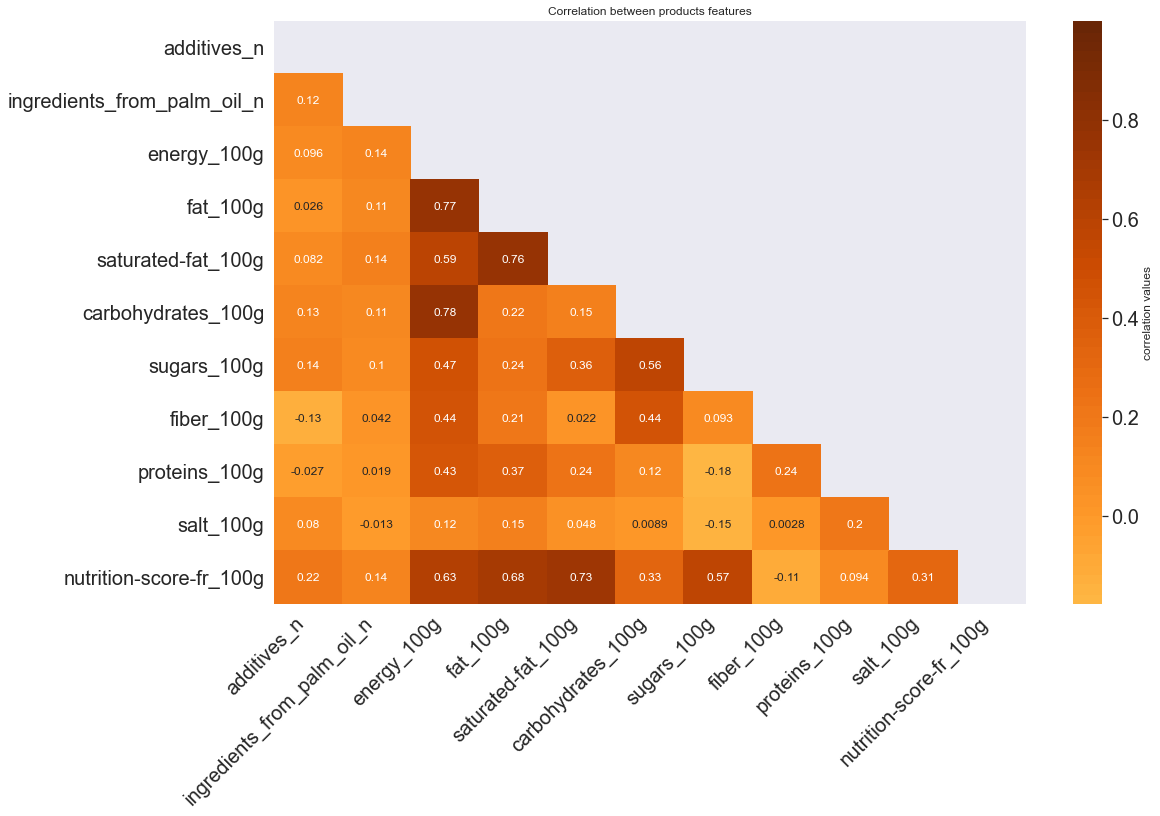

In [64]:

color_map = sns.color_palette("YlOrBr", n_colors =100)

ax=plt.subplots(figsize=(15,10))
ax = sns.heatmap(df_c.corr(), annot=True, center=0,mask=np.triu(np.ones_like(df_c.corr(), dtype=bool)), cmap = color_map, cbar_kws={'label': 'correlation values', 'ticks':np.arange(-1,1,0.2)})
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45,ha='right')
ax.set_title("Correlation between products features")
plt.show()


From the heatmap, we see that that the nutrition score correlate with the saturated fats, energy, and sugar and correlate less with fiber and proteins (Saturated fat are part of the fat therefore we see correlation also with fat)
***

From another representation, we could come up with the same conclusion

In [65]:

ax = plt.subplots(figsize=(15,10))
colormap = sns.color_palette("Paired",n_colors =11)
ax = df_c.drop(['nutrition-score-fr_100g','ingredients_from_palm_oil_n','additives_n'],axis=1).corrwith(df_c['nutrition-score-fr_100g']).plot(kind = 'barh', color = colormap)
ax.grid(True)
ax.set_xlim(left=-1, right=1)
plt.title("Correlation between features")
sns.set()


***
Let's see if the correlation change from one food category to another.

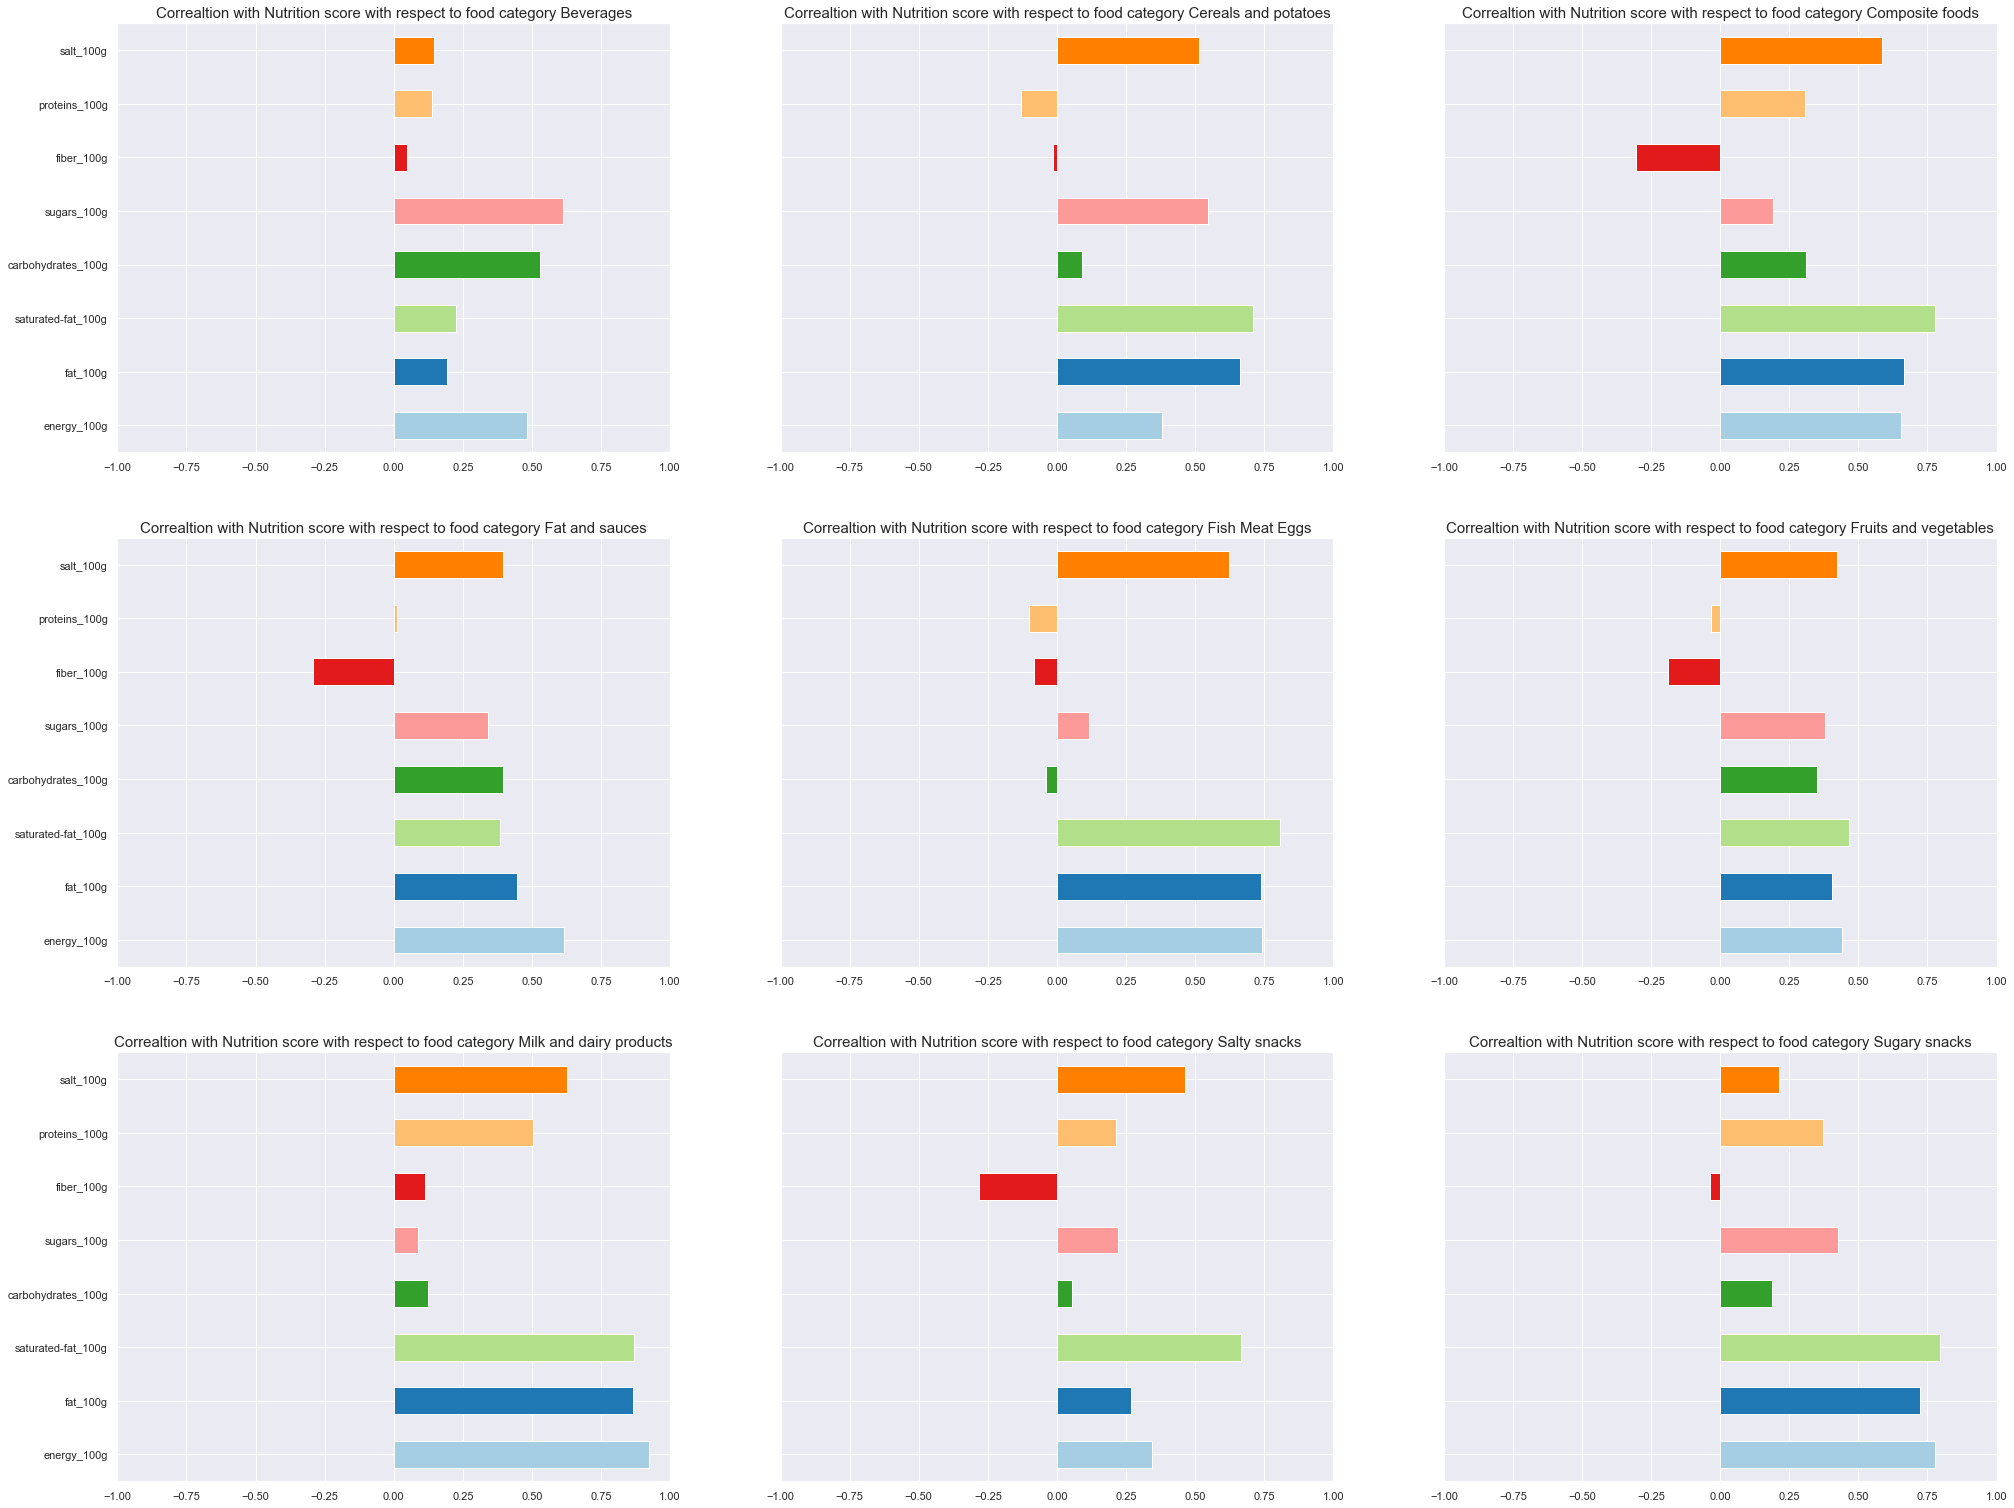

In [66]:

fig, axes = plt.subplots(
    3, 3, figsize=(30, 25)
)

i=0
for (category, plot_col) in zip(
    df_c.groupby('categories').count().index, [0, 1, 2, 0, 1, 2, 0, 1, 2]  # pairing feature with column in plot
    ):
        k=i
        colormap = sns.color_palette("Paired",n_colors =11)
        ax = df_c.loc[(df_c['categories'] == category)].drop(['nutrition-score-fr_100g',
                                                              'ingredients_from_palm_oil_n',
                                                              'additives_n'],axis=1).corrwith(df_c['nutrition-score-fr_100g']).plot(kind='barh'
                                                                                                                                    ,ax=axes[k, plot_col] ,
                                                                                                                                    color = colormap)
        
        axes[k, plot_col].set_title('Correaltion with Nutrition score with respect to food category {}'.format(category),fontsize = 15)
        ax.grid(True)
        ax.set_xlim(left=-1, right=1)
        
        if (plot_col == 1) | (plot_col == 2):
            ax.set_yticklabels('') 

        if plot_col == 2:
            i+=1

sns.set()

* From the barplot we could see clearly the nutrient that impact most the nutriational score are: 
    * Nutrient that cause low nutrition score:
        * Fiber
        * Protiens
    * Nutrient that cause high nutrition score:
        * Saturated fat 
        * Energy
        * sugar 
        * Salt
***